T= 0.0


/share/apps/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:74: RuntimeWarning: divide by zero encountered in true_divide
/share/apps/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:116: RuntimeWarning: invalid value encountered in double_scalars
/share/apps/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in double_scalars


T= 0.1
T= 0.2
T= 0.30000000000000004
T= 0.4
T= 0.5
T= 0.6000000000000001
T= 0.7000000000000001
T= 0.8
T= 0.9
T= 1.0
T= 1.1
T= 1.2000000000000002
T= 1.3
T= 1.4000000000000001
T= 1.5
T= 1.6
T= 1.7000000000000002
T= 1.8
T= 1.9000000000000001
T= 2.0
T= 2.1
T= 2.2
T= 2.3000000000000003
T= 2.4000000000000004
T= 2.5
T= 2.6
T= 2.7
T= 2.8000000000000003
T= 2.9000000000000004
T= 3.0
T= 3.1
T= 3.2
T= 3.3000000000000003
T= 3.4000000000000004
T= 3.5
T= 3.6
T= 3.7
T= 3.8000000000000003
T= 3.9000000000000004
T= 4.0
T= 4.1000000000000005
T= 4.2
T= 4.3
T= 4.4
T= 4.5
T= 4.6000000000000005
T= 4.7
T= 4.800000000000001
T= 4.9
T= 5.0


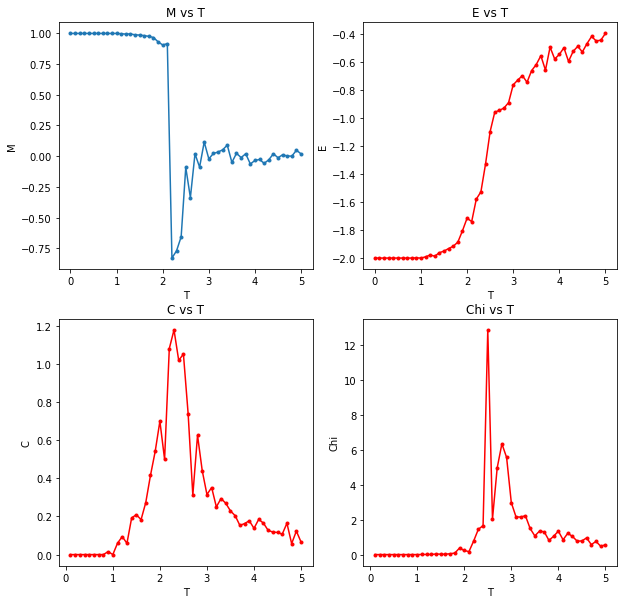

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from random import choice
import os

def spin_init(L,alinged=False):
    if alinged==False:
        lattice= np.reshape([choice([-1,1]) for i in range(L) for j in range(L)],(L,L))
#        lattice=np.random.rand(L,L)
#        for i in range(L):    # i for row(y), j for column(x)
#            for j in range(L):
#                if lattice[i][j]>0.5:
#                    lattice[i][j]=1
#                else: 
#                    lattice[i][j]=-1
    if alinged==True:
#        lattice=np.ones([L,L])
        lattice=np.array(L*L*[1]).reshape(L,L)
    return lattice

## set your parameters here ##############
L=10;          ###=10  for trouble shooting; 50   for production run
N_run=100;     ###=100 for trouble shooting; 2000 for production run
fracN_ss=0.5   ### = 0.5 default. Must be a fractional number >=0 && < 1.
DeltaT=0.1     ###=1.0 for trouble shooting; 0.05 for production run
Tini=0.000;Tlast=5.0;  #default: Tini=0.0; Tlast=5.0
lattice=spin_init(L,alinged=False)
## end of set your parameters here ##############

# calculation of magnetization of the lattice
def magnetization(lattice,L):
    mag=0
    for i in range (L):
        for j in range(L):
            mag+=lattice[i][j]
    return mag


# calculation of interaction energy of each spin and total lattice energy
def energy_site(lattice,L,i,j):
    def BC_1(index,L):
        if index-1<0:
            return L-1

        else:
            return index-1

    def BC_2(index,L):
        if index+1>L-1:
            return 0

        else:
            return index+1

    return lattice[i][j]*(lattice[BC_1(i,L)][j]+lattice[BC_2(i,L)][j]+lattice[i][BC_1(j,L)]+lattice[i][BC_2(j,L)])


def energy_total(lattice,L):
    sum=0
    for i in range(L):
        for j in range(L):
            sum-=energy_site(lattice,L,i,j) # -ve sign due to -J (ferromagnetic) in the hamitonian
    
    return sum/2 # correct for overcounting due to overlapping


# determine if a spin is flipped according to monte-carlo rules
def flip(lattice,L,T):
    for i in range(L):
        for j in range(L):
            if energy_site(lattice,L,i,j)<0:
                lattice[i][j]=-lattice[i][j]
            else:
                if np.e**(-2*energy_site(lattice,L,i,j)/T)>np.random.uniform(0,1):
                    lattice[i][j]=-lattice[i][j]


# the main calculation routine to calculate the values
def main(lattice,L,N_run,T):
    M=0
    m=0
    M_sq=0
    E=0
    e=0
    E_sq=0
    
    ### stepping only lattice; no data sampling #####
    for k in range (N_ss):
        flip(lattice,L,T)
    
    count=0    
    for k in range (N_ss,N_run):
        flip(lattice,L,T)
        m=magnetization(lattice,L)
        M+=m
        M_sq+=m**2
        e=energy_total(lattice,L)
        E+=e
        E_sq+=e**2
        count=count+1
        Tr=round(T,1)
        if os.path.isdir('data/'+str(Tr)):
            donothing=0
        else:
            os.mkdir('data/'+str(Tr))    
        
        latfn=str(round(Tr,2))+'i'+str(count)+'.dat'
        print(latfn)
        np.savetxt('data/'+str(Tr)+'/'+latfn,lattice,delimiter=' ', fmt='%d', 
                   header='L='+str(L)+'; N_run-N_ss='+str(N_run-N_ss)+'; T='+str(T)+'; count='+str(count))
    
    M_mean=M/(N_run-N_ss)
    M_var=M_sq/(N_run-N_ss)-M_mean**2
    E_mean=E/(N_run-N_ss)
    E_var=E_sq/(N_run-N_ss)-E_mean**2
    C=E_var/T**2/L**2
    Chi=M_var/T/L**2

    return [M_mean/L**2,E_mean/L**2,C,Chi,lattice]

### initialization ####
N_ss = int(fracN_ss*N_run);   ### step at which sampling of data begins
#len0=4
ctn=[];dummy=[];
import shutil
cwd=os.getcwd()
if os.path.isdir('data'):
    shutil.rmtree('data')
else:
    os.mkdir('data')    
### initialization ####

### begin calculation ##########
for T in np.arange(Tini,Tlast+DeltaT,DeltaT):
    print("T=",T)
    dummy0=main(lattice,L,N_run,T)
    dummy=dummy0[:-1]
    dummy.insert(0, T)
    ctn.append(dummy)
### use the lattice from the last run 
    lattice=dummy0[-1]
#    print(lattice)
### end calculation ##########

### post processing output    
ctn=np.array(ctn)    
T=np.arange(Tini,Tlast+DeltaT,DeltaT)
M=np.ndarray.flatten(np.hsplit(ctn,5)[1])
E=np.ndarray.flatten(np.hsplit(ctn,5)[2])
C=np.ndarray.flatten(np.hsplit(ctn,5)[3])
Chi=np.ndarray.flatten(np.hsplit(ctn,5)[4])
### end of post processing output

### visualisation
fig=plt.figure(figsize=(10,10))
ax1=plt.subplot(2,2,1)
ax1.plot(T,M,'.-')
ax1.set_title("M vs T")
ax1.set_xlabel("T")
ax1.set_ylabel("M")

ax2=plt.subplot(2,2,2)
ax2.plot(T,E,'.-r')
ax2.set_title("E vs T")
ax2.set_xlabel("T")
ax2.set_ylabel("E")        

ax3=plt.subplot(2,2,3)
ax3.plot(T,C,'.-r')
ax3.set_title("C vs T")
ax3.set_xlabel("T")
ax3.set_ylabel("C")        

ax3=plt.subplot(2,2,4)
ax3.plot(T,Chi,'.-r')
ax3.set_title("Chi vs T")
ax3.set_xlabel("T")
ax3.set_ylabel("Chi") 

plt.show()

np.savetxt('MC_2DIsing.txt',ctn,delimiter=' ',header='L='+str(L)+' N_run='+str(N_run)+'; T M E C Chi')


# check code

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from random import choice
import os

def spin_init(L,alinged=False):
    if alinged==False:
        lattice= np.reshape([choice([-1,1]) for i in range(L) for j in range(L)],(L,L))
#        lattice=np.random.rand(L,L)
#        for i in range(L):    # i for row(y), j for column(x)
#            for j in range(L):
#                if lattice[i][j]>0.5:
#                    lattice[i][j]=1
#                else: 
#                    lattice[i][j]=-1
    if alinged==True:
#        lattice=np.ones([L,L])
        lattice=np.array(L*L*[1]).reshape(L,L)
    return lattice

## set your parameters here ##############
L=10;          ###=10  for trouble shooting; 50   for production run
N_run=100;     ###=100 for trouble shooting; 2000 for production run
fracN_ss=0.5   ### = 0.5 default. Must be a fractional number >=0 && < 1.
DeltaT=0.1     ###=1.0 for trouble shooting; 0.05 for production run
Tini=0.000;Tlast=5.0;  #default: Tini=0.0; Tlast=5.0
lattice=spin_init(L,alinged=False)
## end of set your parameters here ##############

# calculation of magnetization of the lattice
def magnetization(lattice,L):
    mag=0
    for i in range (L):
        for j in range(L):
            mag+=lattice[i][j]
    return mag


# calculation of interaction energy of each spin and total lattice energy
def energy_site(lattice,L,i,j):
    def BC_1(index,L):
        if index-1<0:
            return L-1

        else:
            return index-1

    def BC_2(index,L):
        if index+1>L-1:
            return 0

        else:
            return index+1

    return lattice[i][j]*(lattice[BC_1(i,L)][j]+lattice[BC_2(i,L)][j]+lattice[i][BC_1(j,L)]+lattice[i][BC_2(j,L)])


def energy_total(lattice,L):
    sum=0
    for i in range(L):
        for j in range(L):
            sum-=energy_site(lattice,L,i,j) # -ve sign due to -J (ferromagnetic) in the hamitonian
    
    return sum/2 # correct for overcounting due to overlapping


# determine if a spin is flipped according to monte-carlo rules
def flip(lattice,L,T):
    for i in range(L):
        for j in range(L):
            if energy_site(lattice,L,i,j)<0:
                lattice[i][j]=-lattice[i][j]
            else:
                if np.e**(-2*energy_site(lattice,L,i,j)/T)>np.random.uniform(0,1):
                    lattice[i][j]=-lattice[i][j]


# the main calculation routine to calculate the values
def main(lattice,L,N_run,T):
    M=0
    m=0
    M_sq=0
    E=0
    e=0
    E_sq=0
    
    ### stepping only lattice; no data sampling #####
    for k in range (N_ss):
        flip(lattice,L,T)
    
    count=0    
    for k in range (N_ss,N_run):
        flip(lattice,L,T)
        m=magnetization(lattice,L)
        M+=m
        M_sq+=m**2
        e=energy_total(lattice,L)
        E+=e
        E_sq+=e**2
        count=count+1
        Tr=round(T,1) # ????????????????????
        if os.path.isdir('data/'+str(Tr)):
            donothing=0
        else:
            os.mkdir('data/'+str(Tr))    
        
        latfn=str(round(Tr,2))+'i'+str(count)+'.dat'
        print(latfn)
        np.savetxt('data/'+str(Tr)+'/'+latfn,lattice,delimiter=' ', fmt='%d', 
                   header='L='+str(L)+'; N_run-N_ss='+str(N_run-N_ss)+'; T='+str(T)+'; count='+str(count))
    
    M_mean=M/(N_run-N_ss)
    M_var=M_sq/(N_run-N_ss)-M_mean**2
    E_mean=E/(N_run-N_ss)
    E_var=E_sq/(N_run-N_ss)-E_mean**2
    C=E_var/T**2/L**2
    Chi=M_var/T/L**2

    return [T,M_mean/L**2,E_mean/L**2,C,Chi,lattice]

### initialization ####
N_ss = int(fracN_ss*N_run);   ### step at which sampling of data begins
#len0=4
ctn=[];dummy=[];
import shutil
cwd=os.getcwd()
if os.path.isdir('data'):
    shutil.rmtree('data')
else:
    os.mkdir('data')    
### initialization ####

### begin calculation ##########
for T in np.arange(Tini,Tlast+DeltaT,DeltaT):
    print("T=",T)
    dummy0=main(lattice,L,N_run,T)
    dummy=dummy0[:-1]
    ctn.append(dummy)

# it seems like this part is not nccessary
### use the lattice from the last run
    lattice=dummy0[-1]
#    print(lattice)
### end calculation ##########

### post processing output    
ctn=np.array(ctn)    
T=np.arange(Tini,Tlast+DeltaT,DeltaT)
M=np.ndarray.flatten(np.hsplit(ctn,5)[1])
E=np.ndarray.flatten(np.hsplit(ctn,5)[2])
C=np.ndarray.flatten(np.hsplit(ctn,5)[3])
Chi=np.ndarray.flatten(np.hsplit(ctn,5)[4])
### end of post processing output

### visualisation
fig=plt.figure(figsize=(10,10))
ax1=plt.subplot(2,2,1)
ax1.plot(T,M,'.-')
ax1.set_title("M vs T")
ax1.set_xlabel("T")
ax1.set_ylabel("M")

ax2=plt.subplot(2,2,2)
ax2.plot(T,E,'.-r')
ax2.set_title("E vs T")
ax2.set_xlabel("T")
ax2.set_ylabel("E")        

ax3=plt.subplot(2,2,3)
ax3.plot(T,C,'.-r')
ax3.set_title("C vs T")
ax3.set_xlabel("T")
ax3.set_ylabel("C")        

ax3=plt.subplot(2,2,4)
ax3.plot(T,Chi,'.-r')
ax3.set_title("Chi vs T")
ax3.set_xlabel("T")
ax3.set_ylabel("Chi") 

plt.show()

np.savetxt('MC_2DIsing.txt',ctn,delimiter=' ',header='L='+str(L)+' N_run='+str(N_run)+'; T M E C Chi')
